from google.colab import drive
drive.mount('/content/drive',force_remount=True)


In [1]:
# rm -rf m5000

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd ..

/


In [4]:
!cp '/content/drive/MyDrive/m30000.zip' content

In [3]:
cd content

/content


In [6]:
!unzip m30000.zip -d m30000

Archive:  m30000.zip
replace m30000/Black chaff/008c03cb-b359-41f6-ace9-7dc6a950c2fb.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os

folder_path = "m30000/"  # Replace with your folder path

# List all files in the folder
file_list = os.listdir(folder_path)

# Get the number of files
num_files = len(file_list)

print("Number of files in the folder:", num_files)


Number of files in the folder: 8


In [5]:
import tensorflow as tf

directory="m30000"
dataset=tf.keras.utils.image_dataset_from_directory(
    directory,
    shuffle= True,
    batch_size=32,
    image_size=(256, 256),

)

Found 2826 files belonging to 8 classes.


In [6]:
class_names=dataset.class_names
class_names

['Black chaff',
 'Brown rust',
 'Crown and Root Rot',
 'Healthy Wheat',
 'Leaf Rust',
 'Powdery mildew',
 'Wheat Loose Smut',
 'Yellow rust']

In [7]:
def get_dataset_partition(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):



    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)  # Fixed variable name

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(int(test_split * ds_size))
    val_ds = ds.skip(train_size + int(test_split * ds_size)).take(val_size)

    return train_ds, test_ds, val_ds


In [8]:
train_ds, test_ds, val_ds=get_dataset_partition(dataset)

In [9]:
print(len(train_ds)*32,len(test_ds)*32,len(val_ds)*32)

1984 544 256


In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model

# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
n_classes = 8  # Change the number of classes to 8

# Load the pre-trained DenseNet121 model (excluding the top classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Define the Squeeze-and-Excitation (SE) block
def se_block(input_tensor, ratio=8):
    channel_dim = input_tensor.shape[-1]
    squeeze = layers.GlobalAveragePooling2D()(input_tensor)
    excitation = layers.Dense(channel_dim // ratio, activation='relu')(squeeze)
    excitation = layers.Dense(channel_dim, activation='sigmoid')(excitation)
    excitation = layers.Reshape((1, 1, channel_dim))(excitation)
    scaled = layers.Multiply()([input_tensor, excitation])
    return scaled

# Add your custom classification head with SE block
x = se_block(base_model.output)  # Apply SE block
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer

# Modify the output layer for 8 classes
output = layers.Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=251
)

Epoch 1/251
62/62 [==============================] - 31s 227ms/step - loss: 2.1834 - accuracy: 0.3328 - val_loss: 1.3441 - val_accuracy: 0.5117
Epoch 2/251
62/62 [==============================] - 8s 124ms/step - loss: 1.5007 - accuracy: 0.4531 - val_loss: 1.1573 - val_accuracy: 0.5742
Epoch 3/251
62/62 [==============================] - 8s 126ms/step - loss: 1.3078 - accuracy: 0.5143 - val_loss: 0.9998 - val_accuracy: 0.6523
Epoch 4/251
62/62 [==============================] - 8s 126ms/step - loss: 1.1734 - accuracy: 0.5729 - val_loss: 0.9051 - val_accuracy: 0.6641
Epoch 5/251
62/62 [==============================] - 8s 128ms/step - loss: 1.0798 - accuracy: 0.6065 - val_loss: 0.8078 - val_accuracy: 0.7031
Epoch 6/251
62/62 [==============================] - 8s 132ms/step - loss: 0.9632 - accuracy: 0.6366 - val_loss: 0.7593 - val_accuracy: 0.7109
Epoch 7/251
62/62 [==============================] - 8s 133ms/step - loss: 0.8662 - accuracy: 0.6871 - val_loss: 0.6752 - val_accuracy: 0.773

In [ ]:
tf.keras.backend.clear_session()
del train_ds
del val_ds


In [14]:
import gc
gc.collect()

4

In [15]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
scores=model.evaluate(test_ds)
scores

17/17 [==============================] - 3s 118ms/step - loss: 0.9738 - accuracy: 0.9210


[0.9737744331359863, 0.9209558963775635]

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
import matplotlib.pyplot as plt
import math

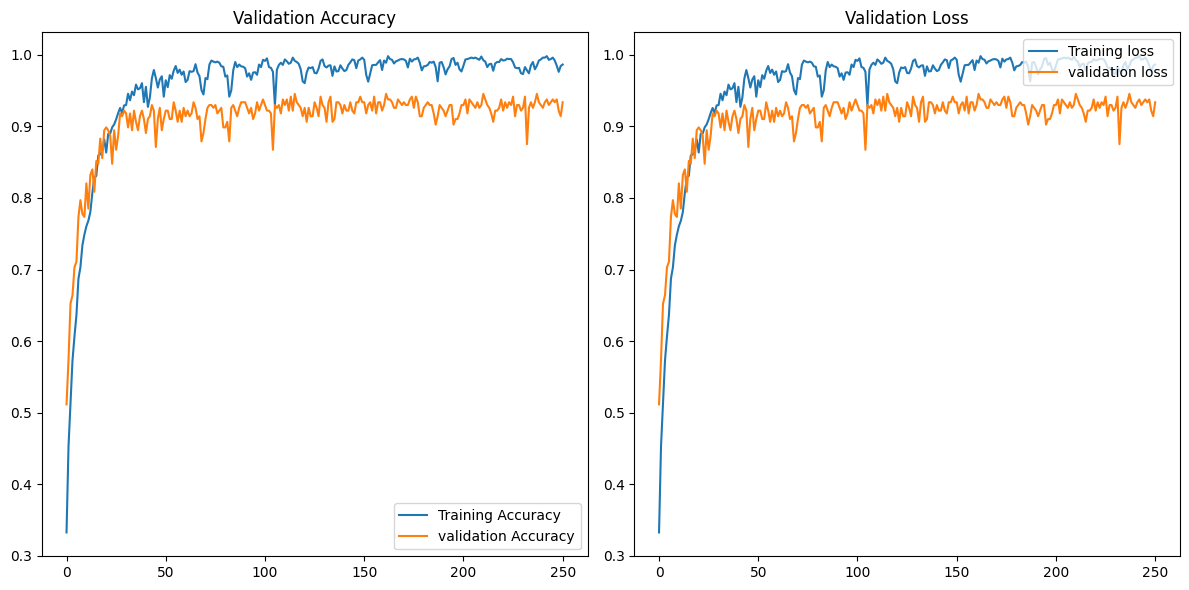

In [28]:
EPOCHS=251
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training')

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),val_acc,label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),acc,label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),val_acc,label='validation loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')



plt.tight_layout()
plt.show()

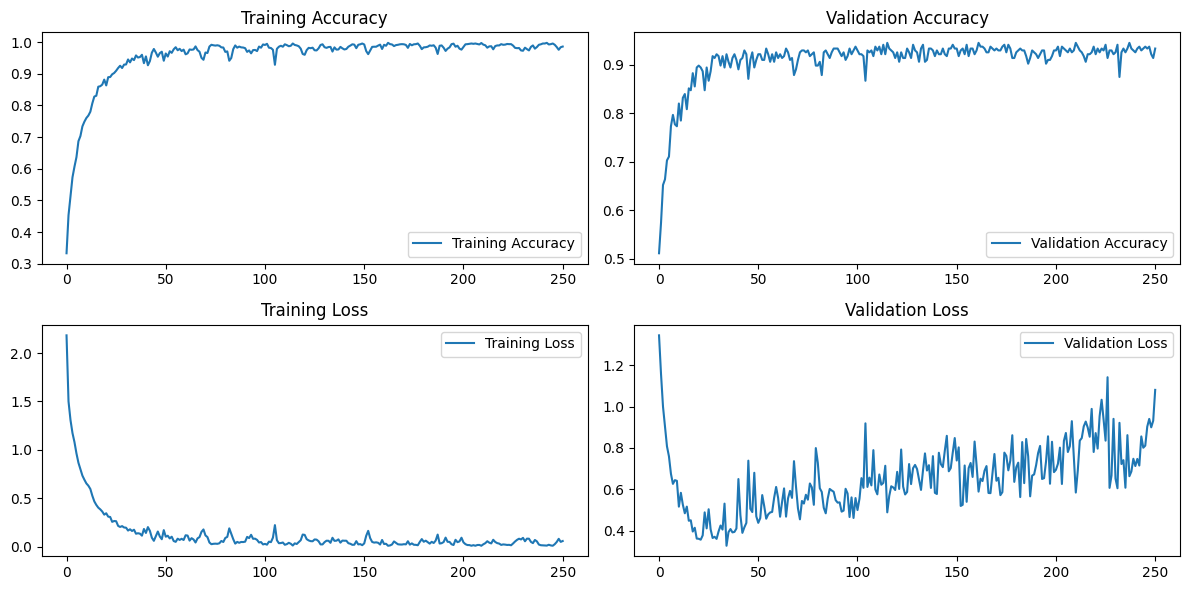

In [19]:
EPOCHS=251
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2,2,3)
plt.plot(range(EPOCHS), loss, label='Training Loss')  # Changed to 'loss'
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(2,2,4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')  # Changed to 'val_loss'
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.tight_layout()
plt.show()


first image to predict
label:  Wheat Loose Smut
1/1 [==============================] - 2s 2s/step
predicted Label:  Wheat Loose Smut


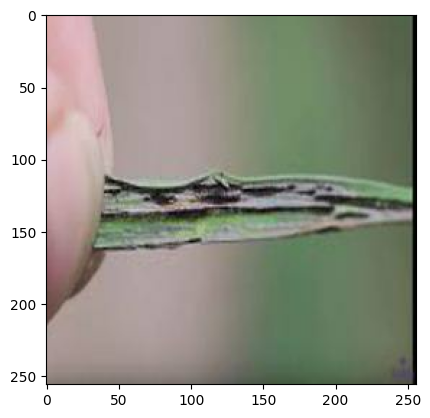

In [20]:
i=5
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image=images_batch[i].numpy().astype("uint8")

  print("first image to predict")
  plt.imshow(first_image)

  print("label: ", class_names[labels_batch[i].numpy()])
  batch_prediction=model.predict(images_batch)
  print("predicted Label: ",class_names[np.argmax(batch_prediction[i])])

In [21]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)
  predicted_class= class_names[np.argmax(predictions[0])]
  confidence=round(100*np.max(predictions[0]),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 49ms/step


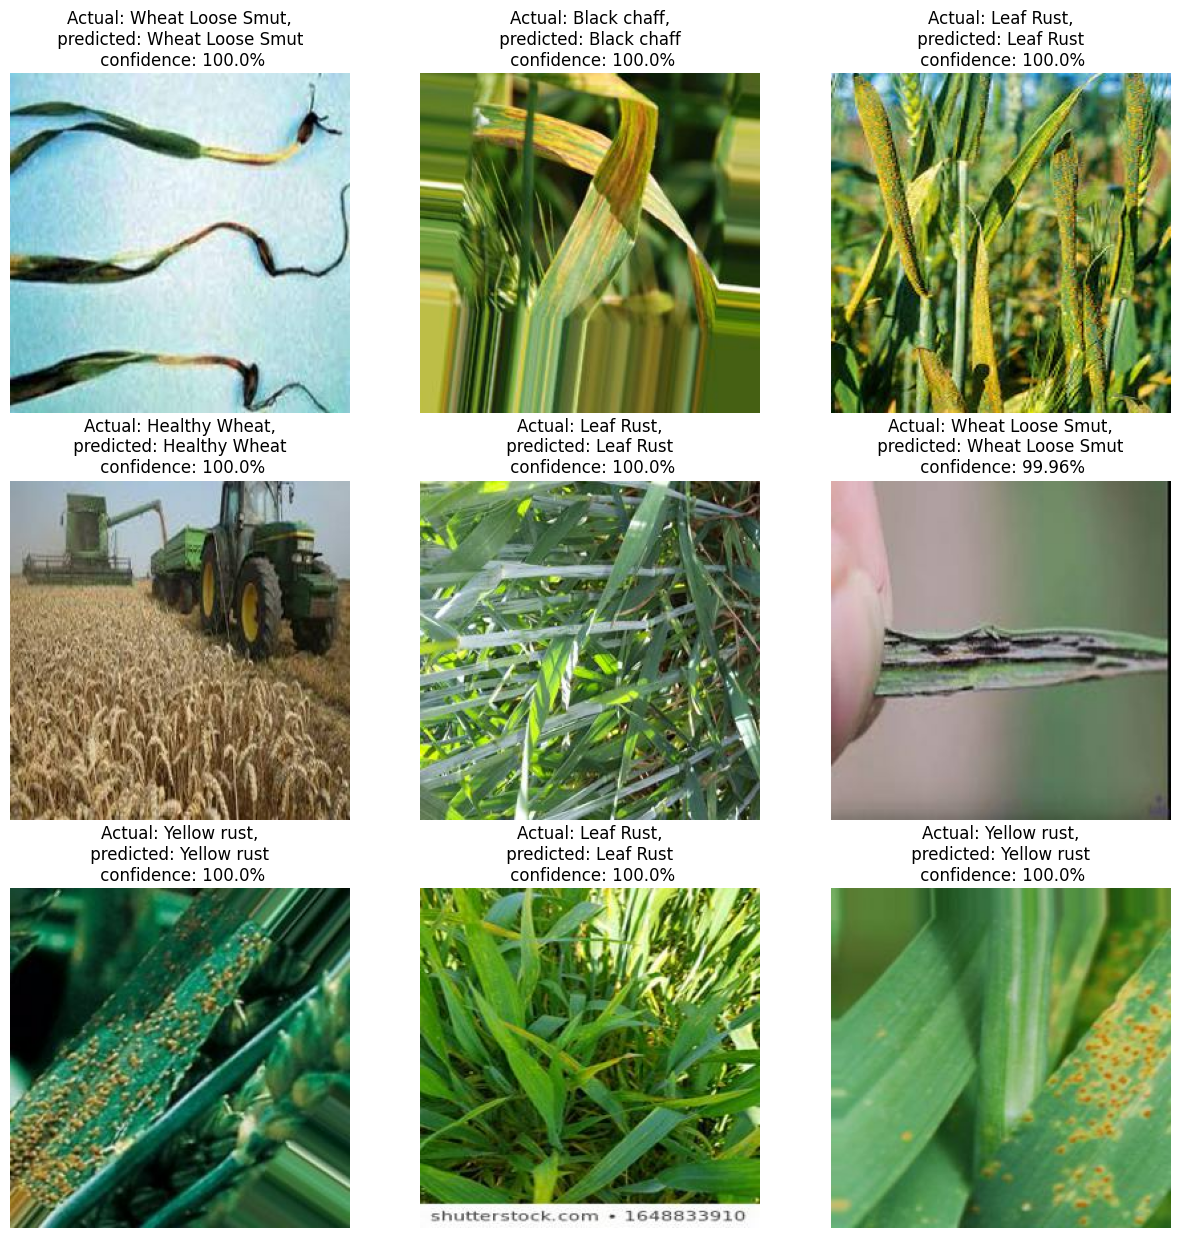

In [29]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):

  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())

    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n predicted: {predicted_class} \n confidence: {confidence}%")
    plt.axis("off")

In [23]:
import zipfile
from google.colab import files
import os

In [24]:
model.save('m_model_squeeze.h5')